In [59]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from IPython.display import display, clear_output, Javascript
import numpy as np
from ipywidgets import interact, Layout
import ipywidgets as widgets
import itertools
import pandas as pd
import networkx.algorithms.community as nxcom
from pylab import *
import hvplot.networkx as hvnx
from bokeh.models import HoverTool
import decorator

For this code to run properly it is imporatnt to have a version of decorator 5.0.7 or higher. If the version on your computer turns out to be lower, run
```python
!pip install decorator==5.0.9
```
or upgrade decorator with the commands discussed in Chapter 1.

In [60]:
decorator.__version__

'5.0.9'

 Load the graph that was pickled in the previous notebook

In [61]:
with open('pickle/treasury.p', 'rb') as p: 
    G = pickle.load(p)
file = 'csv/treasury_shoes2.txt'
tr_df = pd.read_csv(file, encoding='utf8')
ids = list(tr_df['id_text'])
ids.sort()

# Visualization Functions
This function helps to find the proportional size of the node. By Colman Bouton.

In [63]:
def node_size_calculator(graph, property_name, minSize, maxSize):
    '''Given the graph, the property_name which we will use as a size reference, 
     and the minSze and maxSize, calculate the relative size of the nodes'''
    node_data = graph.nodes.data(data=property_name)
    data_max = max([v for k,v in node_data])
    data_min = min([v for k,v in node_data])
    return {k: int(minSize + v/(data_max-data_min)*(maxSize-minSize)) 
          for k,v in node_data}

There are several things that are key to creating good positioning for a graph visualization using the spring layout. First, we must use an undirected version of the graph for spring calculations. Otherwise, nodes that have a single directed edge leading into them will not be attracted to any other node and simply fly off.

Additionally, unless the user specifies otherwise, we use the degree of the two nodes of an edge to weaken the strength of the spring. Generally, since degree represents the number of visual features around a node, this will produce the best visualisation.

A further consideration to be had is that if the graph is not connected, its components will fly away from each other without bound. Therefore, it is essential for any graph you might be drawing with spring_layout that it is connected. We will be addressing this issue in our own graph at a later step.

Function by Colman Bouton

In [64]:
def spring_position_calculator(graph, weight_property_name = None, 
                               spring_seed = None):

    gcopy = graph.to_undirected()

    if weight_property_name == None:
        weight_property_name = 'degree'
        for node in gcopy.nodes:
            gcopy.nodes[node]['degree'] = gcopy.degree[node]
  
    avg_weight = np.median([v for k,v in gcopy.nodes().data(data = weight_property_name)]) #used for draw weight calculation
    overall_reduce = 1 / gcopy.number_of_nodes()**0.5
    for edge in gcopy.edges:
    #calculate draw_weight for each edge
        gcopy[edge[0]][edge[1]]['draw_weight'] = overall_reduce * avg_weight * gcopy[edge[0]][edge[1]]['weight'] / (min(gcopy.nodes[edge[0]][weight_property_name], 
                                                                                                                        gcopy.nodes[edge[1]][weight_property_name]) + 0.01 * avg_weight)
  
    pos = nx.spring_layout(gcopy, weight = 'draw_weight', 
                         iterations = 500, seed=spring_seed)
    return pos

Now we can put all this to together and create a function that draws a pretty graph! We will default to using a spring graph, as well as taking in some arguments that will allow us to parameterize the size of the nodes and input which metric we will use to color code the nodes with.

Function by Colman Bouton.

In [111]:
def draw_pretty_graph(graph, minSize, maxSize,
                            size_attr_name, figure, color_attr_name = 'degree',
                            spacing_attr_name = None, label_name = None, pos = None, 
                            label_cutoff = 1, spring_seed = None, Ego=None):
    '''Draw a pretty graph using the graph argument and resize the nodes using the
     minSize and maxSize argments, while coloring the nodes by a determined metric'''
  
  # first, we use our previously defined function to create a dict for the sizes
    node_sizes = node_size_calculator(graph, size_attr_name, minSize, maxSize)

  # then we create the list of values for our colormap
    color_values = list(nx.get_node_attributes(graph, color_attr_name).values())
    v_min = min(color_values)
    v_max = max(color_values)

  # if positions are not specified, calculate them using the previous function
    if pos == None:
        pos = spring_position_calculator(graph, spacing_attr_name)

    # we now position the labels:
    label_pos = {}
    num_labels = int(G.number_of_nodes() * label_cutoff) # calculate number of labels to show
    for node in sorted(node_sizes, key = node_sizes.get, reverse=True)[0:num_labels]:
      # set the label position to be slightly offset from the node position
        label_pos[node] = [pos[node][0], pos[node][1] + 0.03]
    if Ego:
        label_pos[Ego] = [pos[Ego][0], pos[Ego][1] + 0.03]

  # draw nodes and edges
    nx.draw_networkx_nodes(        
          graph,
          pos,
          node_size = [node_sizes[node] for node in graph],
          node_color= color_values,
          alpha = 1,
          cmap= plt.cm.plasma, 
          vmax = v_max,
          vmin = v_min,
          )
    nx.draw_networkx_edges(        
          graph,
          pos,
          node_size = [node_sizes[node] for node in graph],
          alpha = 0.5,
          edge_color = 'brown',
          width = 2,
          connectionstyle="arc3,rad=0.1"
          )
  
  # draw labels if provided
    if label_name == None:  # this the default option: use the node indexes
        labels = {k : k for k in label_pos}
        nx.draw_networkx_labels(graph, label_pos, labels = labels, 
                            font_size = 14, font_weight = 'bold', 
                            font_color = 'black') #, ax = ax)
    elif label_name != False: #if label_name is False, dont't draw labels
        labels = {k:graph.nodes.data(data = label_name)[k] for k in label_pos}
        nx.draw_networkx_labels(graph, label_pos, labels = labels, 
                            font_size = 14, font_weight = 'bold', 
                            font_color = 'black') #, ax = ax)
    
  # draw the colorbar
    norm = mpl.colors.Normalize(vmin = v_min, vmax = v_max)
    options = {'label' : color_attr_name}
    figure.colorbar(mpl.cm.ScalarMappable(norm, plt.cm.plasma), **options)

# Visualizing the Graph
Generally speaking, we found setting the edges to be transparent made the graph easier to read, and that making the graph sufficiently large helped us see the individual nodes.

We also chose to color code the nodes based on an assignable metric, which we defaulted to node degree. This makes it easier to discern which nodes are more important. We added a colorbar as a legend for the metric.

In spring graphs, the nodes are set to pull apart from each other and the edges act as springs pulling the nodes together. When the positions are being calculated, the repellant forces and the attractant forces through the springs are added up over a series of iterations until the graph settles into a particular set of positions. In some cases, when there is a large set of data, you might see the nodes clump together, making the nodes difficult to interpret individually.

Here we take the largest connected subgraph and use the `draw_pretty_graph` helper function to draw our network using a spring graph. 

Most of the nodes in our graph are pretty small, meaning they have a pretty low degree, but we see some interesting main actors. These nodes end up at the center of our graph because they are fairly well connected and thus are only pulled apart by less connected nodes.

By Colman Bouton

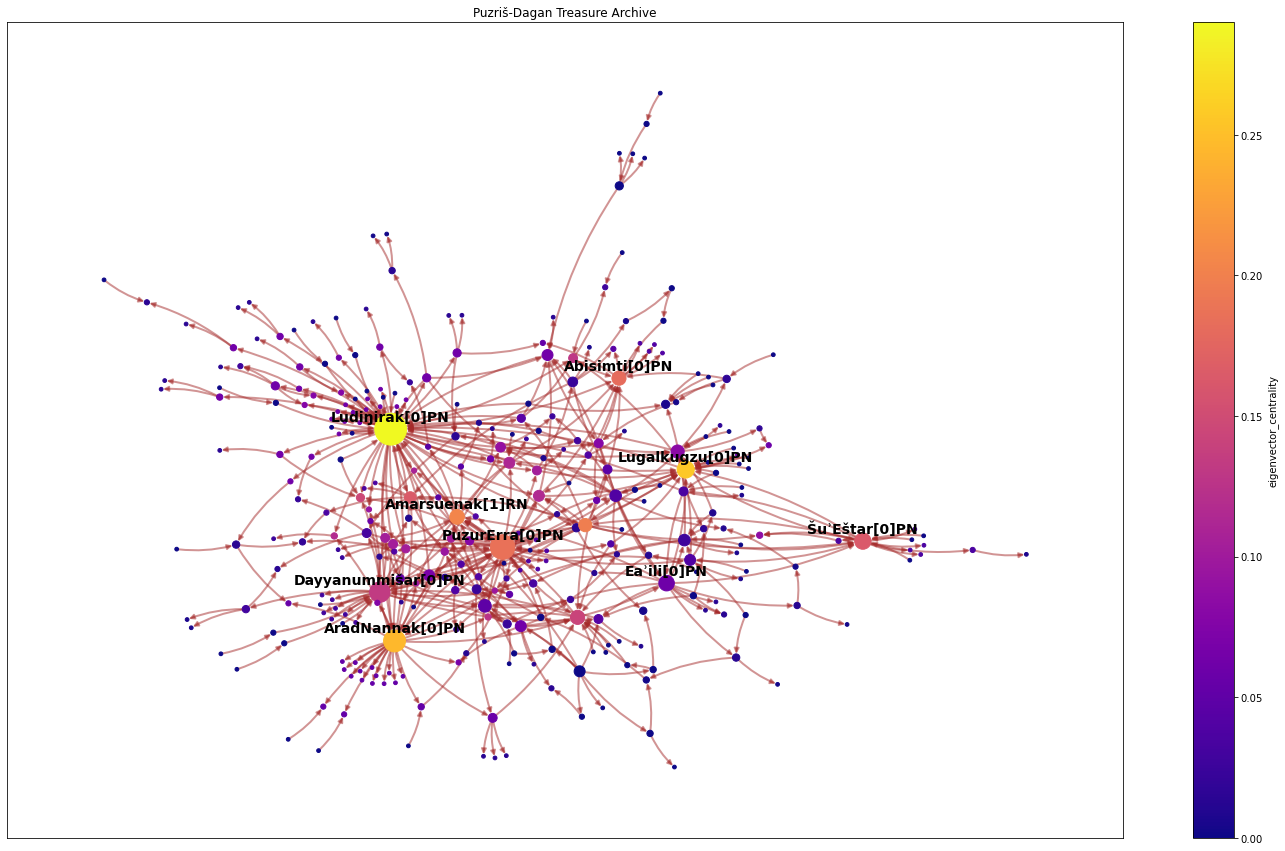

In [116]:
# remove nodes which have no connections to other nodes in the graph
mainc = max(nx.algorithms.components.connected_components(G.to_undirected()), 
            key = len)
I = G.subgraph(mainc).copy()
#degreelog = {name : np.log(I.degree[name]) for name in I.nodes}
#nx.set_node_attributes(I, degreelog, "degreelog")

# draw the graph using draw_pretty_graph helper function

figure = plt.figure(figsize=(25, 15))
draw_pretty_graph(I, 1, 1000, "degree", figure,
                  color_attr_name = 'eigenvector_centrality',
                  label_name = None, label_cutoff = 0.03, spring_seed=1);
plt.title('Puzriš-Dagan Treasure Archive');

In [117]:
mainc = max(nx.algorithms.components.connected_components(G.to_undirected()), 
            key = len)
I = G.subgraph(mainc).copy()   # create new version
#I = nx.convert_node_labels_to_integers(I)
pos = spring_position_calculator(I)
node_sizes = node_size_calculator(I, "degree", 5, 1000)
node_size_list = list(node_sizes.values())
number_of_names_to_display = 10
add_labels = sorted(node_sizes, key=node_sizes.get, reverse=True)[:number_of_names_to_display]
label_dict = {name : name if name in add_labels else "" for name in I.nodes}

#no_label = [ind for ind, label in enumerate(I.nodes) if not label in add_labels]

In [122]:
gr = hvnx.draw(I,
          pos,
          height=800,
          width=900,
          node_size = node_size_list, #hvnx.dim('node_size')*5, #hvnx.dim('degree')*50,
          arrowhead_length=0.005,
          with_labels=True,
          labels=label_dict,
          edge_width='weight',
          edge_alpha= 0.7,
          edge_color='brown',
          node_color='eigenvector_centrality',
          node_cmap=plt.cm.plasma,
          )
hvnx.save(gr, "interactive.html")

In [123]:
gr

:Overlay
   .Graph.I  :Graph   [start,end]   (edge_color,edge_size,edge_type,max_date,min_date,weight)
   .Labels.I :Labels   [x,y]   (text)

In [106]:
labels = {k:I.nodes(data = False)[k] for k in I.nodes}

In [107]:
labels

{'Abisimti[0]PN': {'degree': 15,
  'eigenvector_centrality': 0.18171725297916763},
 'Damu[1]DN': {'degree': 1, 'eigenvector_centrality': 0.03966320720630645},
 'Gemenannak[0]PN': {'degree': 2,
  'eigenvector_centrality': 0.04461995046802612},
 'Gunura[1]DN': {'degree': 1, 'eigenvector_centrality': 0.03966320720630645},
 'Ninisinak[0]PN': {'degree': 1,
  'eigenvector_centrality': 0.03966320720630645},
 'Nuhilum[0]PN': {'degree': 2, 'eigenvector_centrality': 0.05347678706220454},
 'Šumah[1]DN': {'degree': 1, 'eigenvector_centrality': 0.03966320720630645},
 'Abumbašti[0]PN': {'degree': 2,
  'eigenvector_centrality': 0.003955605800533212},
 'PuzurEštar[0]PN': {'degree': 6,
  'eigenvector_centrality': 0.07818057304848494},
 'Abuni[0]PN': {'degree': 6, 'eigenvector_centrality': 0.03237797641266063},
 'Abba[0]PN': {'degree': 2, 'eigenvector_centrality': 0.013384058904573457},
 'Abuṭab[0]PN': {'degree': 3, 'eigenvector_centrality': 0.012317665349371745},
 'KAL.bi.si[0]PN': {'degree': 2,
  'eig